# **SIFT (Scale-Invariant Feature Transform) Algorithm Overview**

SIFT is a robust computer vision technique for local feature detection and description.

## Steps:

1. **Scale Space:** Build Gaussian pyramids for different scales.
2. **DoG Pyramid:** Compute Difference of Gaussians for keypoint detection.
3. **Keypoint Detection:** Identify potential keypoints from DoG extrema.
4. **Keypoint Refinement:** Refine keypoints based on stability criteria.
5. **Orientation Assignment:** Assign dominant orientations to keypoints.
6. **Descriptor Generation:** Create local feature descriptors around keypoints.
7. **Matching and Recognition:** Match descriptors for object recognition, image stitching, etc.

SIFT's ability to detect and describe robust local features across scales makes it widely used in various computer vision applications.


### We first include necessary libraries and add a normalization function and a function for visualizing images

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform
import skimage.io as io
from skimage.color import rgb2gray
from skimage.filters import sobel_h, sobel_v
from skimage.transform import rotate
import pandas as pd
import cv2
import time
%matplotlib inline

In [2]:
def normalize_img(img):
    """
    Normalize pixel values of an image to the range [0, 1].

    Parameters:
    - img (numpy.ndarray): Input image as a NumPy array.

    Returns:
    - numpy.ndarray: Normalized image with pixel values in the range [0, 1].

    Example:
    >>> img = np.array([[10, 20, 30], [40, 50, 60]])
    >>> normalize_img(img)
    array([[0. , 0.2, 0.4],
           [0.6, 0.8, 1. ]])
    """
    img_min = np.min(img)
    img_max = np.max(img)
    normalized_img = (img - img_min) / (img_max - img_min)
    return normalized_img


In [3]:
def show_images(imgs, imgs_labels=None, figsize=(20, 10)):
    """
    Display images horizontally using Matplotlib subplots.

    Parameters:
    - imgs: List of images (NumPy arrays) to display.
    - imgs_labels: (Optional) List of labels corresponding to the images.

    Example Usage:
    show_images([image1, image2], ['Label 1', 'Label 2'])
    """
    # Create a figure with subplots based on the number of images
    fig, axes = plt.subplots(1, len(imgs), figsize=figsize)

    # Plot each image on its respective subplot
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i], cmap="gray")  # Display image in grayscale
        if imgs_labels:
            axes[i].set_title(imgs_labels[i])  # Set title if labels provided

    # Show the plot
    plt.tight_layout()
    plt.show()


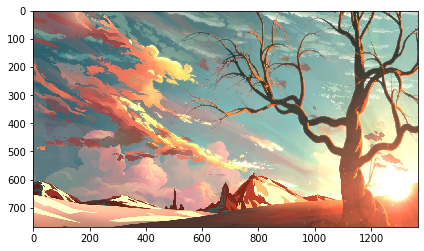

In [4]:
img_ = io.imread("img.jpg")
io.imshow(img_)
plt.show()

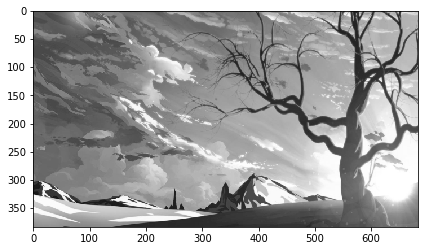

In [5]:
# convert to grayscale and normalize
img_ = normalize_img(rgb2gray(img_))
img_ = transform.rescale(img_, 0.5)
io.imshow(img_, cmap='gray')
plt.show()

**Before starting, some terminologies must be clear**

Scale: Refers to the level or degree of Gaussian blurring applied to an image. It determines the amount of detail present in different versions of the same image.

Octave: A set of images having the same size, but with different scales (gaussian lvls)

Scale space: It encompasses the collection of octaves, each containing a series of images at varying scales (achieved by applying Gaussian blurring and downsampling). The scale space is essentially the entire set of images generated through different octaves and their respective scales.

## Step1: Construct Scale Space.


In [6]:
def downsample_img(img, lvls):
    """
    Generates a list of images by downsampling the input image at different levels.

    Parameters:
    - img: Input image (NumPy array).
    - lvls: List of downsampling levels.

    Returns:
    - generated_imgs: List of images downsampled at different levels.
    """
    generated_imgs = [cv2.resize(img, (0, 0), fx=1.0/lvl, fy=1.0/lvl) for lvl in lvls]
    return generated_imgs


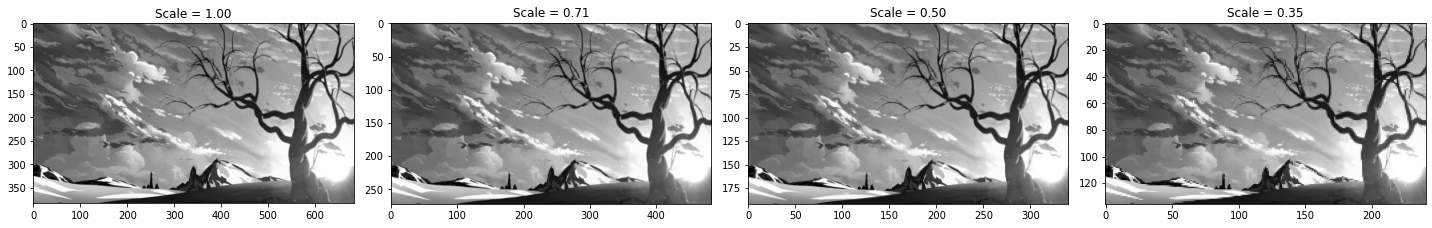

In [7]:
downsampling_lvls = [1.0]
num_downsamples = 4

for i in range(num_downsamples - 1):
    downsampling_lvls.append(np.sqrt(2) * downsampling_lvls[-1])

downsampled_imgs = downsample_img(img_, downsampling_lvls)
show_images(downsampled_imgs, [f"Scale = {1/i:.2f}" for i in downsampling_lvls])

In [8]:
def create_octave(img, sigmas):
    """
    Generates a list of images by applying Gaussian blur to the input image at different sigma values.

    Parameters:
    - img: Input image (NumPy array).
    - sigmas: List of sigma values for Gaussian blurring.

    Returns:
    - generated_imgs: List of images blurred at different sigma values.
    """
    blurred_images = [cv2.GaussianBlur(img, (0, 0), sigmaX=sigma, sigmaY=sigma) for sigma in sigmas]
    return blurred_images


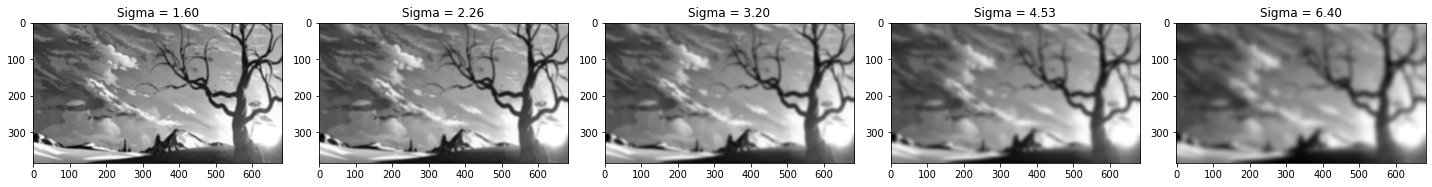

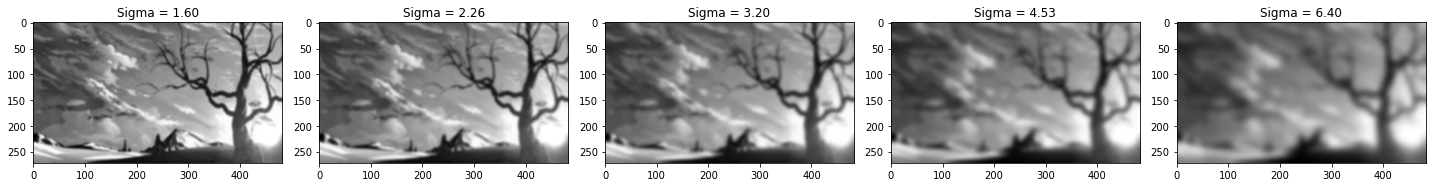

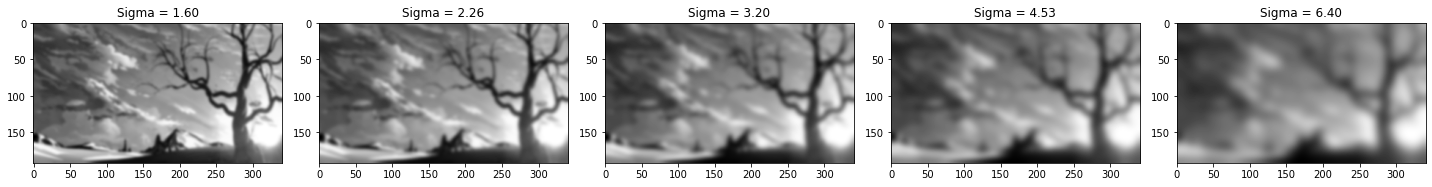

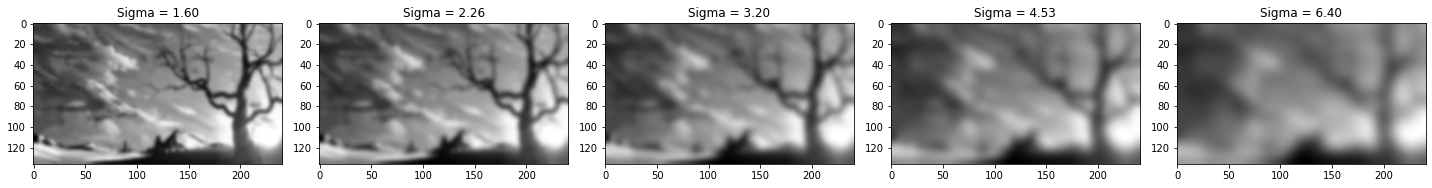

In [9]:
scale_space = []
sigma = 1.6
k = np.sqrt(2)

sigmas = [sigma, k * sigma, k**2 * sigma, k**3 * sigma, k**4 * sigma]
for i in range(len(downsampled_imgs)):
    blurred_imgs = create_octave(downsampled_imgs[i], sigmas)
    show_images(blurred_imgs, [f"Sigma = {i:.2f}" for i in sigmas])
    scale_space.append(blurred_imgs)

## Step2: Compute Difference of Gaussians for keypoint detection.

In [10]:
def get_doG(imgs_list):
    """
    Computes the Difference of Gaussians (doG) for a list of images.

    Parameters:
    - imgs_list: List of images.

    Returns:
    - doG_list: List of images representing the differences between consecutive scales.
    """
    doG_list = [imgs_list[i - 1] - imgs_list[i] for i in range(1, len(imgs_list))]
    return doG_list

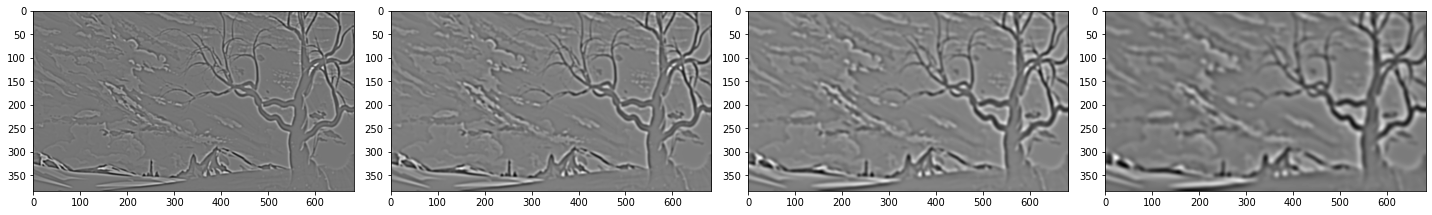

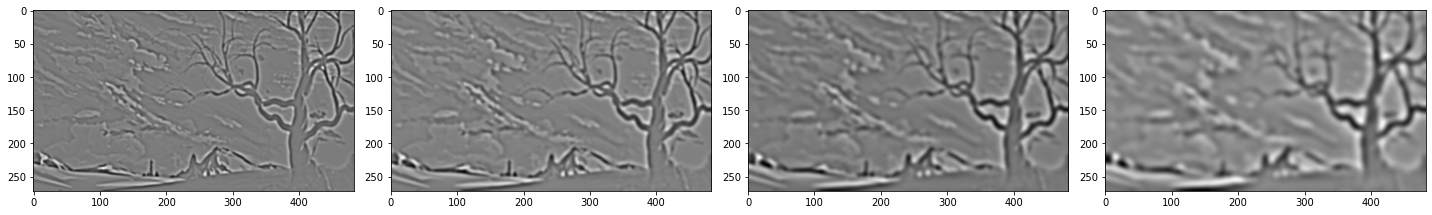

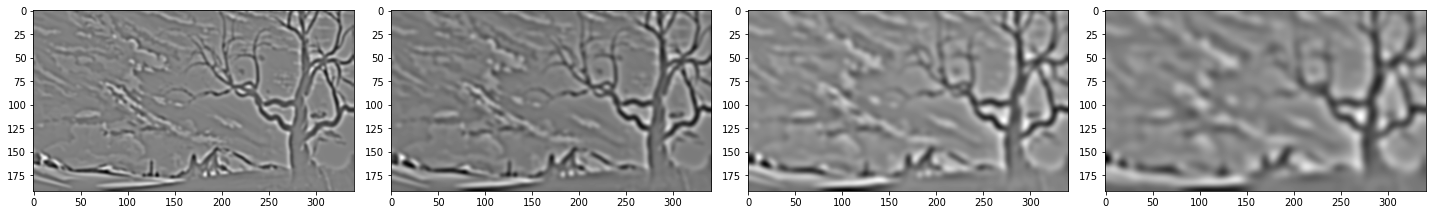

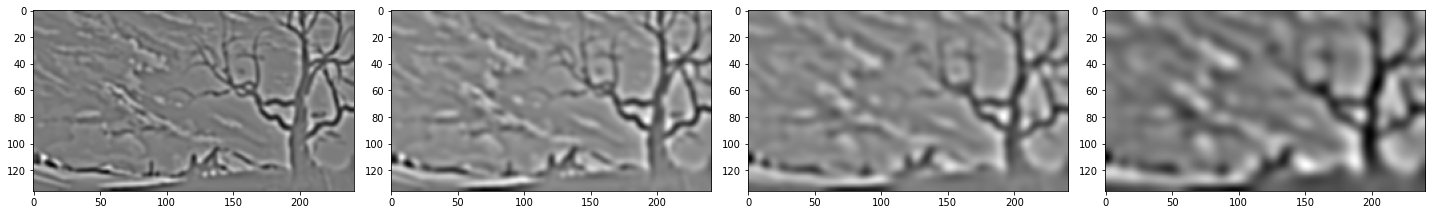

In [11]:
doG_space = []
for imgs_list in scale_space:
    doG_list = get_doG(imgs_list)
    doG_space.append(doG_list)
    show_images(doG_list)

## Step3: Keypoint Detection
Identify potential keypoints from doG extrema.

A keypoint in an image is a corner point, and in order to determine whether a point is a corner point or not, we use something called *Harris corner detector*

The Harris corner detector is an algorithm used in computer vision to identify corners or interest points in an image. It's not specifically an edge detector but is often used alongside edge detection methods for feature extraction.

#### Functionality

The Harris corner detection algorithm operates by:

1. **Image Gradients:**
   - Calculating gradients in the image to find changes in intensity in both x and y directions.

2. **Structure Tensor Calculation:**
   - Computing the structure tensor for each pixel, involving the products of gradients.

3. **Sum of Squares of Gradients:**
   - Calculating the sum of squares of gradients using the structure tensor elements.

4. **Corner Response Function:**
   - The cornerstone of the Harris corner detection algorithm is the corner response function.
   - It evaluates the local change in intensity for small displacements in different directions around a pixel.
   - The function assesses the significance of intensity changes when the image is shifted.
   - Mathematically, the corner response function is defined as:
     ```
     R = det(M) - k * trace(M)^2
     ```
     - Where:
       - `det(M)` is the determinant of the structure tensor `M`.
       - `trace(M)` is the trace of the structure tensor `M`.
       - `k` is an empirically determined constant (typically 0.04 to 0.06).
   - Higher values of `R` indicate a stronger response and a higher likelihood of the pixel being part of a corner or an interest point.

5. **Thresholding or Non-Maximum Suppression:**
   - Applying a threshold or non-maximum suppression to the computed corner response values to identify potential corners or interest points.


In [12]:
from numba import jit
@jit(nopython=True)
def get_keypoints(doG_list, i, thresh=0.003):  # check that image values are between 0 and 1
    """
    Detects potential keypoints in Difference of Gaussian (doG) images.

    Args:
    - doG_list (list of arrays): A list containing Difference of Gaussian images.
    - i (int) : Idx of the image in the Different of gaussian images (doG).
    - thresh (float): Threshold value for identifying potential keypoints (default: 0.55).

    Returns:
    - total_keypoints (list of lists of tuples): A list containing coordinates of identified keypoints for each doG image.

    Notes:
    - The function iterates through the doG images in 'doG_list' and identifies potential keypoints.
    - 'thresh' determines the sensitivity of keypoint detection.
    - Output 'total_keypoints' contains lists of keypoints corresponding to each doG image.
    """
    candidate_keypoints = []
    H, W = doG_list[0].shape
    
    full_tensor = np.empty((3,) + doG_list[0].shape)  # Create an empty array to hold stacked data
    full_tensor[0] = doG_list[i-1]
    full_tensor[1] = doG_list[i]
    full_tensor[2] = doG_list[i+1]
    for y in range(1, H-1):
        for x in range(1, W-1):
            if(np.abs(doG_list[i][y, x]) > thresh):
                tensor = full_tensor[:, y-1:y+2, x-1:x+2]
                if(doG_list[i][y, x] == np.max(tensor) or doG_list[i][y, x] == np.min(tensor)):
                    candidate_keypoints.append([x, y])
    
    return candidate_keypoints

## Step4: Keypoint Refinement
Refine keypoints based on stability criteria.

In [13]:
def filter_keypoints(img, keypoints, dxx, dyy, dxy, r=10, patch_size=5):
    """
    Filter keypoints based on the Hessian matrix determinant ratio.

    Parameters:
    - img: Input image.
    - keypoints: List of keypoints, where each keypoint is represented as a tuple (x, y).
    - dxx, dyy, dxy: Second derivatives of the image in x, y directions.
    - r: Parameter controlling the acceptance of keypoints based on Hessian determinant ratio.
        Keypoints with a ratio below ((r + 1)^2) / r are accepted.
    - patch_size: Size of the neighborhood patch for computing derivatives.

    Returns:
    List of filtered keypoints based on the Hessian determinant ratio.
    Each filtered keypoint is represented as a tuple (x, y).
    """
    filtered_keypoints = []

    for kp in keypoints:
        x, y = kp
        
        # Calculate the Hessian matrix at the keypoint location
        y_start, y_end = int(y - patch_size/2), int(y + patch_size/2)
        x_start, x_end = int(x - patch_size/2), int(x + patch_size/2)
        
        dxx_ = dxx[y_start:y_end, x_start:x_end]
        dyy_ = dyy[y_start:y_end, x_start:x_end]
        dxy_ = dxy[y_start:y_end, x_start:x_end]

        if dxx_.any():
            # Construct the Hessian matrix
            H = np.array([[np.sum(dxx_**2), np.sum(dxy_**2)],
                           [np.sum(dxy_**2), np.sum(dyy_**2)]])

            # Calculate the Hessian determinant ratio
            ratio = (H[0, 0] + H[1, 1])**2 / (np.linalg.det(H) + 1e-8)
            
            # Check if the keypoint satisfies the Hessian determinant ratio condition
            if(x < img.shape[1] - 1 and y < img.shape[0] - 1):
                if ratio < ((r + 1)**2) / r:
                    filtered_keypoints.append((x, y))
    return filtered_keypoints


In [14]:
# test keypoints filteration
# for i in range(1, len(doG_list)-1):  # i is the scale (blur lvl)
i = 1
doG_i = doG_space[0][i]

# get keypoints of this doG
%time keypoints = get_keypoints(np.array(doG_space[0]), i)  # numba is faster if the input is a np array

# calculate first and second derivatives of the image in both x, y directions 
dx = sobel_h(doG_i)
dy = sobel_v(doG_i)
dxx = sobel_h(dx)
dyy = sobel_v(dy)
dxy = sobel_h(dy)

# calculate magnitude and direction for this doG img
gradient_magnitude, gradient_orientation = cv2.cartToPolar(dx, dy, angleInDegrees=True)


filtered_keypoints = filter_keypoints(doG_i, keypoints, dxx, dyy, dxy)
    
    

Wall time: 2.59 s


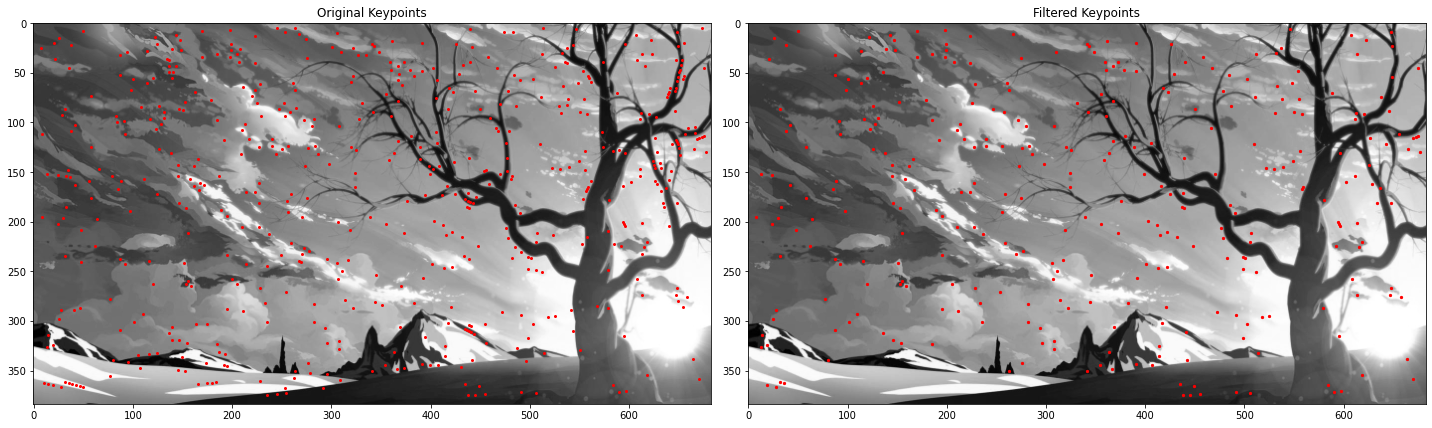

In [15]:
# plot keypoints before and after refinement
plt.figure(figsize=(20, 7))

x = [obj[0] for obj in keypoints]
y = [obj[1] for obj in keypoints]

plt.subplot(1, 2, 1)
plt.imshow(img_, cmap='gray')
plt.scatter(x, y, s=4, c="red")
plt.title('Original Keypoints')

# Filtered Keypoints plot
keypointsarr_filtered1 = np.array(filtered_keypoints)

plt.subplot(1, 2, 2)
plt.imshow(img_, cmap='gray')
plt.scatter(keypointsarr_filtered1[:, 0], keypointsarr_filtered1[:, 1], s=5, c="red")
plt.title('Filtered Keypoints')

plt.tight_layout()
plt.show()

## Step5: Orientation Assignment
Assign dominant orientations to keypoints.

In [16]:
def get_dominant_angles(filtered_keypoints, gradient_magnitude, gradient_orientation, patch_size=26):
    """
    Calculate dominant angles for filtered keypoints based on local gradient information.

    Parameters:
    - filtered_keypoints: List of filtered keypoints, where each keypoint is represented as a tuple (x, y).
    - gradient_magnitude: Gradient magnitude image.
    - gradient_orientation: Gradient orientation image.
    - patch_size: Size of the neighborhood patch for computing orientations.

    Returns:
    - orientation_data: Dictionary mapping each keypoint to a list of dominant angles.
    - new_filtered_keypoints: List of keypoints that passed the patch size check.
    """
    orientation_data = {}
    new_filtered_keypoints = []

    for kp in filtered_keypoints:
        x, y = kp
        y_start, y_end = int(y - patch_size / 2), int(y + patch_size / 2)
        x_start, x_end = int(x - patch_size / 2), int(x + patch_size / 2)
        patch_magnitude = gradient_magnitude[y_start:y_end, x_start:x_end]
        patch_orientation = gradient_orientation[y_start:y_end, x_start:x_end]

        if patch_magnitude.shape == (patch_size, patch_size):
            # Flatten the orientation and magnitude arrays
            flat_magnitude = patch_magnitude.flatten()
            flat_orientation = patch_orientation.flatten()

            # Calculate the weighted histogram of orientations
            hist, bins = np.histogram(flat_orientation, bins=36, range=(0, 360), weights=flat_magnitude)

            # Find the bin index with the maximum value
            max_bin_index = np.argmax(hist)

            # Convert the bin index to the corresponding orientation value
            max_orientation = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2

            orientation_data[kp[:2]] = [max_orientation]
            new_filtered_keypoints.append(kp)

            # Check for additional prominent angles (>0.8 times the peak value)
            hist = np.delete(hist, max_bin_index)
            other_bins = np.where(hist > 0.8)[0]

            if len(other_bins) > 0:
                orientation_data[kp[:2]].extend([(bins[bin] + bins[bin + 1]) / 2 for bin in other_bins])

    return orientation_data, new_filtered_keypoints


## Step 6: Descriptor Generation
Create local feature descriptors around keypoints.

In [36]:
@jit(nopython=True)
def sobel_numba(img):
    rows, cols = img.shape
    grad_x = np.zeros_like(img)
    grad_y = np.zeros_like(img)

    # Sobel kernels
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # Compute gradient in x-direction
            gx = np.sum(img[i-1:i+2, j-1:j+2] * kernel_x)
            # Compute gradient in y-direction
            gy = np.sum(img[i-1:i+2, j-1:j+2] * kernel_y)

            grad_x[i, j] = gx
            grad_y[i, j] = gy

    # Compute magnitude and orientation
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    orientation = np.arctan2(grad_y, grad_x)
    orientation_deg = np.degrees(orientation)
    
    return magnitude, orientation_deg

In [50]:
@jit(nopython=True)
def compute_weighted_histogram(window, weights, num_bins):
    hist = np.array([0 for i in range(num_bins)])
    min_val = -180
    max_val = 180

    bin_edges = np.linspace(min_val, max_val, num_bins + 1)

    for i in range(window.shape[0]):
        for j in range(window.shape[1]):
            value = window[i, j]
            weight = weights[i, j]

            bin_index = np.searchsorted(bin_edges, value, side='right') - 1
            if 0 <= bin_index < num_bins:
                hist[bin_index] += weight

    return hist

In [98]:
@jit(nopython=True)
def get_hist(array, nbins=8):
    """
    Computes a histogram of gradient orientations from an input array.

    Args:
    - array (numpy array): Input array to compute the gradient orientations.
    - nbins (int): Number of bins for the histogram (default: 8).

    Returns:
    - hist (list): Histogram of gradient orientations.

    Notes:
    - Computes gradient magnitudes and angles using Sobel operators on the input array.
    - Generates a histogram of gradient angles with specified bins and magnitude weights.
    - 'nbins' determines the number of bins for the histogram.
    - Output 'hist' contains the histogram of gradient orientations.
    """
    gradient_magnitude, gradient_orientation = sobel_numba(array*256)
    # adjust the weight of each vector based on how far it is from keypoint
    distances = np.ones((4, 4))
    distances[1:3, 1:3] = 4
    
    # # Use Numba array creation for weights
    # weights_numba = np.empty_like(weights)
    # for i in range(len(weights)):
    #     weights_numba[i] = weights[i]

    hist = compute_weighted_histogram(gradient_orientation, gradient_magnitude, nbins)
    # hist, bin_edges = np.histogram(gradient_orientation.flatten(), bins=nbins, 
    #                range=(0, 360), weights=weights * gradient_magnitude.flatten())
    return hist


In [144]:
def get_descriptor(doG_i, kp, rot_angle, patch_size=16, subarray_size=4, func=get_hist):
    half_patch = patch_size // 2
    x, y= kp

    # Check boundaries
    x_start = max(x - half_patch, 0)
    y_start = max(y - half_patch, 0)
    x_end = min(x + half_patch, doG_i.shape[1] - 1)
    y_end = min(y + half_patch, doG_i.shape[0] - 1)
    
    patch = doG_i[y_start:y_end, x_start:x_end]
    if patch.shape != (16, 16):
        return []
    
    # rotate patch with the dominant angle
    patch = rotate(patch, angle=-rot_angle, resize=False, preserve_range=True)

    feature_vector = []
    for row in range(0, patch_size, subarray_size):
        for col in range(0, patch_size, subarray_size):
            subarray = patch[row:min(row + subarray_size, patch_size), col:min(col + subarray_size, patch_size)]
            result = func(subarray)
            feature_vector.extend(result)

    norm = np.linalg.norm(feature_vector)
    if(norm):
        normalized_feature_vector = feature_vector / norm
    else:
        normalized_feature_vector = feature_vector

    return normalized_feature_vector


In [145]:
def get_SIFT_data(img, sigmas, downsampling_lvls=[1], doG_thresh=0.003, r=10):
    SIFT_summary = pd.DataFrame(columns=["Position", "Size", "Orientation", "Descriptor"])
    
    # generate different sizes of the image    
    downsampled_imgs = downsample_img(img, downsampling_lvls)

    # create scale space
    scale_space = []
    for i in range(len(downsampled_imgs)):
        octave = create_octave(downsampled_imgs[i], sigmas)
        scale_space.append(octave)

    for s, imgs_list in enumerate(scale_space):
        doG_list = np.array(get_doG(imgs_list))
        
        for i in range(1, len(doG_list)-1):  # i is the scale (blur lvl)
            doG_i = doG_list[i].astype(np.float32)

            # get keypoints of this doG
            keypoints = get_keypoints(np.array(doG_list), i, doG_thresh)  # numba is faster if the input is a np array

            # calculate first and second derivatives of the image in both x, y directions 
            dx = cv2.Sobel(doG_i, cv2.CV_64F, 1, 0, ksize=3)
            dy = cv2.Sobel(doG_i, cv2.CV_64F, 0, 1, ksize=3)
            dxx = cv2.Sobel(dx, cv2.CV_64F, 1, 0, ksize=3)
            dyy = cv2.Sobel(dy, cv2.CV_64F, 0, 1, ksize=3)
            dxy = cv2.Sobel(dy, cv2.CV_64F, 1, 0, ksize=3)

            # calculate magnitude and direction for this doG img
            gradient_magnitude, gradient_orientation = cv2.cartToPolar(dx, dy, angleInDegrees=True)
            
            # filter keypoints to include only corner points
            filtered_keypoints = filter_keypoints(doG_i, keypoints, dxx, dyy, dxy, r = r)

            orientation_data, filtered_keypoints = get_dominant_angles(filtered_keypoints, gradient_magnitude, gradient_orientation)
        
            start = time.time()
            
            for kp in filtered_keypoints:
                for angle in orientation_data[kp[:2]]:
                    descriptor = get_descriptor(doG_i, kp, angle)
                    if len(descriptor):
                        data = [kp, 1/downsampling_lvls[s], angle, descriptor]
                        SIFT_summary.loc[len(SIFT_summary)] = data
            print(f"Time: {time.time() - start}")
    return SIFT_summary

# Modify this function to return Only list of descriptors and a list of keypoints

In [146]:
# get descriptors of the current image
sigma = 1.6
k = np.sqrt(2)

downsampling_lvls = [1.0]  # Starting scale factor, e.g., 1.0
num_downsamples = 4

for i in range(num_downsamples - 1):
    downsampling_lvls.append(np.sqrt(2) * downsampling_lvls[-1])

sigmas = [sigma, k * sigma, k**2 * sigma, k**3 * sigma, k**4 * sigma]
%time SIFT_summary = get_SIFT_data(img_, sigmas, downsampling_lvls)

Time: 6.601343393325806
Time: 4.685467720031738
Time: 4.458108186721802
Time: 2.165215015411377
Time: 2.72072172164917
Time: 1.6695013046264648
Time: 1.2885534763336182
Time: 0.844740629196167
Wall time: 25.1 s


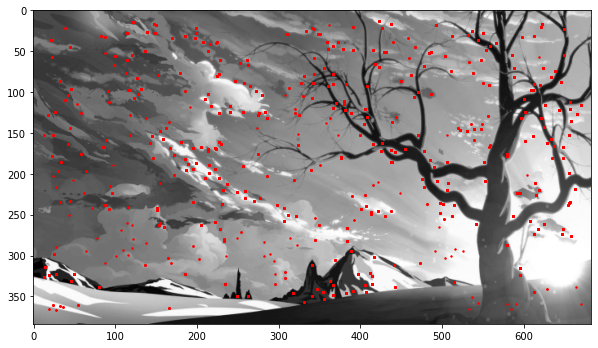

In [105]:
x, y= zip(*SIFT_summary[SIFT_summary["Size"] == 1]["Position"].to_list())
fig = plt.figure(figsize=(10, 8))
plt.imshow(img_, cmap='gray')  # Display the image
plt.scatter(list(x), list(y), color='red', s=2)  # Scatter plot the point (x, y) in red color
plt.show()

## Testing Scale invariance

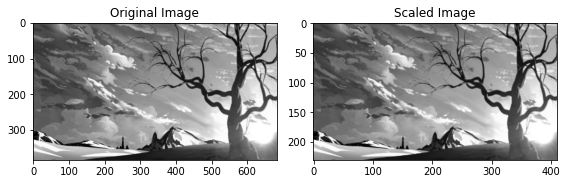

In [106]:
# Create two images with different scales
img_1 = img_
img_2 = transform.rescale(img_1, 0.6)
show_images([img_1, img_2], ["Original Image", "Scaled Image"], figsize=(8, 5))

In [107]:
# Get feature points for each image
SIFT_summary1 = get_SIFT_data(img_1, sigmas, downsampling_lvls, doG_thresh=0.003)
SIFT_summary2 = get_SIFT_data(img_2, sigmas, doG_thresh=0.003)

Time: 5.364650726318359
Time: 3.7541491985321045
Time: 4.196808099746704
Time: 2.170163154602051
Time: 2.5491955280303955
Time: 1.710425615310669
Time: 1.2417054176330566
Time: 0.8328063488006592
Time: 2.784581422805786
Time: 1.687481164932251


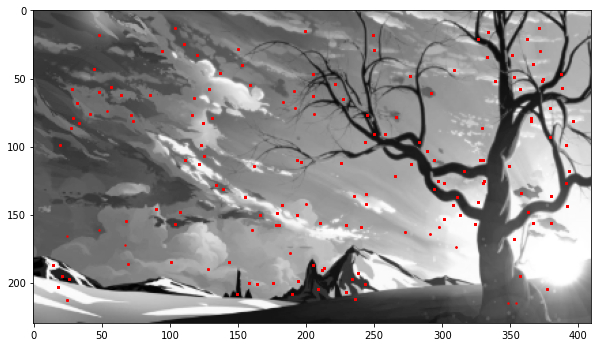

In [108]:
x, y= zip(*SIFT_summary2[SIFT_summary2["Size"] == 1]["Position"].to_list())
fig = plt.figure(figsize=(10, 8))
plt.imshow(img_2, cmap='gray')  # Display the image
plt.scatter(list(x), list(y), color='red', s=2)  # Scatter plot the point (x, y) in red color
plt.show()

In [109]:
# Get nearest neighbor for each feature point
from sklearn.neighbors import NearestNeighbors

k_neighbors = 1  # Number of neighbors to find (in this case, the nearest neighbor)
nn_model = NearestNeighbors(n_neighbors=k_neighbors, algorithm='kd_tree')

# Fit the model on data2 (feature points from image 2)
nn_model.fit(SIFT_summary1["Descriptor"].to_list())

distances, indices = nn_model.kneighbors(SIFT_summary2["Descriptor"].to_list())

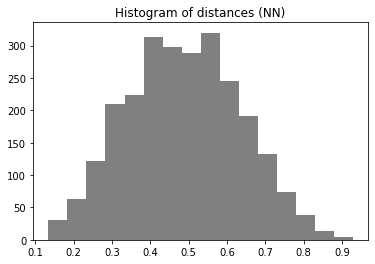

In [110]:
# plot histogram of nearest neighbors distances
_ = plt.hist(distances.reshape(-1), bins=16, color='gray');
plt.title("Histogram of distances (NN)")
plt.show()

In [111]:
# choose some threshold distance and get the corresponding feature points
max_distance = 0.3
filtered_indices = indices[distances < max_distance]
corresponding_rows_SIFT_summary1 = SIFT_summary1.iloc[filtered_indices].reset_index()

# Get corresponding rows from SIFT_summary2 using filtered indices
corresponding_rows_SIFT_summary2 = SIFT_summary2.iloc[distances < max_distance].reset_index()


In [112]:
# Determine the most common scale (Size) in the SIFT features
# by finding the size with the maximum occurrence in the "Size" column
scale_factor = corresponding_rows_SIFT_summary1["Size"].value_counts().idxmax()

# Get indices of rows with the specified scale_factor
indices_filtered_rows1 = corresponding_rows_SIFT_summary1[corresponding_rows_SIFT_summary1["Size"] == scale_factor].index

# Extract corresponding rows from both SIFT summary DataFrames
filtered_rows_SIFT_summary1 = corresponding_rows_SIFT_summary1.loc[indices_filtered_rows1]
filtered_rows_SIFT_summary2 = corresponding_rows_SIFT_summary2.loc[indices_filtered_rows1]

# get x, y points from both SIFT summary df to plot
xy1 = np.array(filtered_rows_SIFT_summary1["Position"].to_list())[:, :2]
x1 = xy1[:, 0]
y1 = xy1[:, 1]

xy2 = np.array(filtered_rows_SIFT_summary2["Position"].to_list())[:, :2]
x2 = xy2[:, 0]
y2 = xy2[:, 1]


In [113]:
from matplotlib.patches import ConnectionPatch
from matplotlib import gridspec

def plot_sift_images(img1, img2, x1, x2, y1, y2, scale_factor):
    """
    Plot SIFT keypoints on two images and connect corresponding points.

    Parameters:
    - img1: First image (numpy array).
    - img2: Second image (numpy array).
    - x1: x-coordinates of keypoints in image 1.
    - x2: x-coordinates of keypoints in image 2.
    - y1: y-coordinates of keypoints in image 1.
    - y2: y-coordinates of keypoints in image 2.
    - scale_factor: Scale factor used for resizing image 1.

    Returns:
    None (displays the plot).
    """
    # Creating subplots with width ratios
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Plotting scatter points on image 1
    ax1 = plt.subplot(gs[0])
    ax1.imshow(transform.rescale(img1, scale_factor), cmap='gray')
    ax1.scatter(x1, y1, color='red', s=5)

    # Plotting scatter points on image 2
    ax2 = plt.subplot(gs[1])
    ax2.imshow(img2, cmap='gray')
    ax2.scatter(x2, y2, color='blue', s=5)

    # Connecting points with ConnectionPatch
    for i in range(len(x1)):
        xyA = (x1[i], y1[i])
        xyB = (x2[i], y2[i])
        con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                              axesA=ax1, axesB=ax2, color="darkgreen", linewidth=0.5)
        ax2.add_artist(con)

    plt.show()


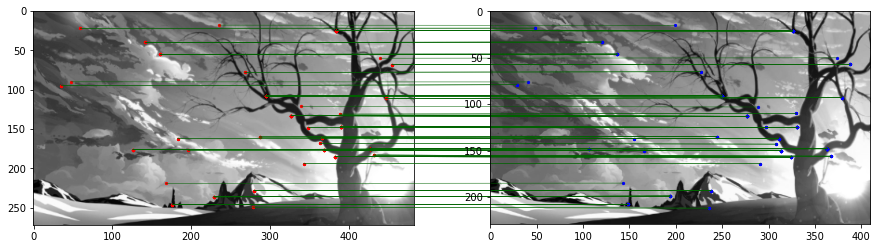

In [114]:
plot_sift_images(img_1, img_2, x1, x2, y1, y2, scale_factor)


## Testing Rotation Invariance

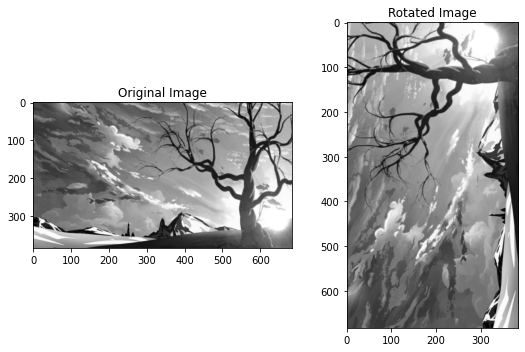

In [115]:
# rotate image with 90 degree
img3 = transform.rotate(img_1, 90, resize=True, preserve_range=True)
show_images([img_1, img3], ["Original Image", "Rotated Image"], figsize=(8, 5))

In [116]:
# Get Feature points descriptors of the rotated image
SIFT_summary3 = get_SIFT_data(img3, sigmas, doG_thresh=0.003)

Time: 5.889247894287109
Time: 5.106340646743774


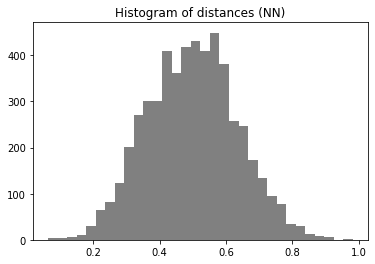

In [120]:
# get nearest neighbor for each feature point in the rotated image
distances, indices = nn_model.kneighbors(SIFT_summary3["Descriptor"].to_list())

# plot histogram of distances
_ = plt.hist(distances.reshape(-1), bins=32, color='gray');
plt.title("Histogram of distances (NN)")
plt.show()

In [121]:
# choose some threshold distance and get the corresponding feature points
max_distance = 0.2
filtered_indices = indices[distances < max_distance]
corresponding_rows_SIFT_summary1 = SIFT_summary1.iloc[filtered_indices].reset_index()

# Get corresponding rows from SIFT_summary2 using filtered indices
corresponding_rows_SIFT_summary3 = SIFT_summary3.iloc[distances < max_distance].reset_index()


In [122]:
# Determine the most common scale (Size) in the SIFT features
# by finding the size with the maximum occurrence in the "Size" column
scale_factor = corresponding_rows_SIFT_summary1["Size"].value_counts().idxmax()

# Get indices of rows with the specified scale_factor
indices_filtered_rows1 = corresponding_rows_SIFT_summary1[corresponding_rows_SIFT_summary1["Size"] == scale_factor].index

# Extract corresponding rows from both SIFT summary DataFrames
filtered_rows_SIFT_summary1 = corresponding_rows_SIFT_summary1.loc[indices_filtered_rows1]
filtered_rows_SIFT_summary3 = corresponding_rows_SIFT_summary3.loc[indices_filtered_rows1]

# get x, y points from both SIFT summary df to plot
xy1 = np.array(filtered_rows_SIFT_summary1["Position"].to_list())[:, :2]
x1 = xy1[:, 0]
y1 = xy1[:, 1]

xy2 = np.array(filtered_rows_SIFT_summary3["Position"].to_list())[:, :2]
x2 = xy2[:, 0]
y2 = xy2[:, 1]


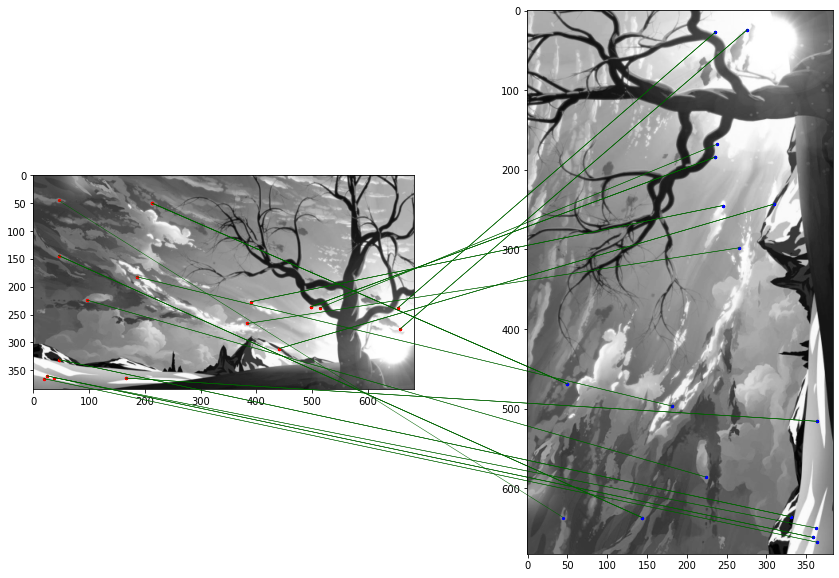

In [123]:
plot_sift_images(img_1, img3, x1, x2, y1, y2, scale_factor)


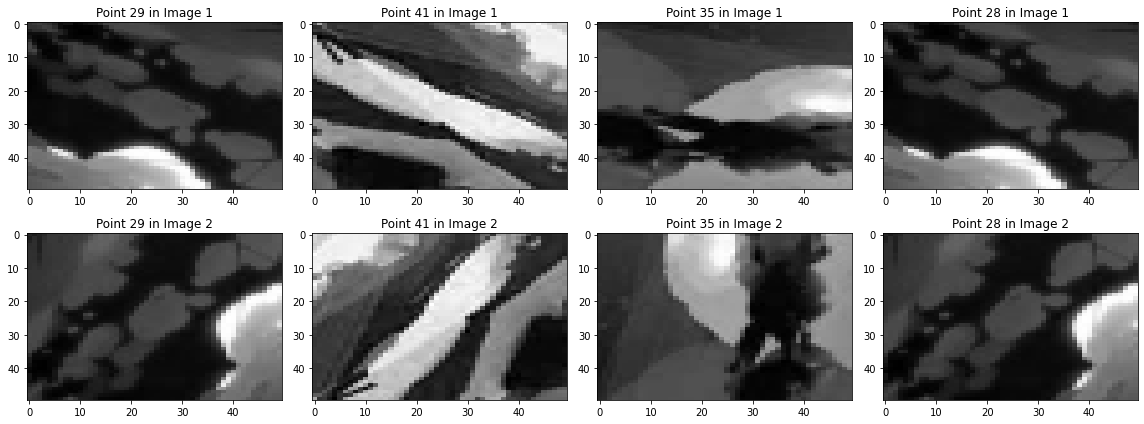

In [125]:
def display_points_with_windows(img1, img2, x1, y1, x2, y2, window_size=50):
    # Create a figure with two rows and four columns
    fig, axs = plt.subplots(2, 4, figsize=(16, 6))

    for i in range(4):
        j = np.random.randint(0, high=len(x1) - 1)
        # Extract the window around the point in img1
        window_img1 = img1[y1[j] - window_size//2:y1[j] + window_size//2, x1[j] - window_size//2:x1[j] + window_size//2]

        # Extract the window around the corresponding point in img2
        window_img2 = img2[y2[j] - window_size//2:y2[j] + window_size//2, x2[j] - window_size//2:x2[j] + window_size//2]

        # Display the window in img1
        axs[0, i].imshow(window_img1, cmap='gray', aspect='auto')
        axs[0, i].set_title(f'Point {j+1} in Image 1')

        # Display the window in img2
        axs[1, i].imshow(window_img2, cmap='gray', aspect='auto')
        axs[1, i].set_title(f'Point {j+1} in Image 2')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

display_points_with_windows(img_1, img3, x1, y1, x2, y2)

In [18]:
# Initialize SIFT detector
sift = cv2.SIFT_create()
img1 = (img_ * 255).astype(np.uint8)
img2 = (img_ * 255).astype(np.uint8)

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
print(len(keypoints2))
# Initialize a BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()

# Match descriptors of both images
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Get common keypoints
common_keypoints_img1 = [keypoints1[match.queryIdx] for match in good_matches]
common_keypoints_img2 = [keypoints2[match.trainIdx] for match in good_matches]

# Draw common keypoints on both images
img1_with_keypoints = cv2.drawKeypoints(img1, common_keypoints_img1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_with_keypoints = cv2.drawKeypoints(img2, common_keypoints_img2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show images with common keypoints
cv2.imshow('Image 1 with Common Keypoints', img1_with_keypoints)
cv2.imshow('Image 2 with Common Keypoints', img2_with_keypoints)
cv2.waitKey(0)
cv2.destroyAllWindows()

1330


# RANSAC algorithm to get affine matrix with nearest neighbor
Given that we have two images, the steps are as follows:
1. Get feature points of both images
2. Get nearest neighbors from image2 for all feature poins in image1
3. Sum distances and store it with it's model in a variable called best matrix
4. Take 3 random points and make an affine matrix
5. Transform the image by the affine matrix
6. Get feature points for image2
7. Repeat steps from 2 - 6

In [131]:
def get_affine_matrix(df1, df2, model):
    # while True:
    # get three random points x, y
    sample_points_df = df2.sample(3)
    
    # Extracting the Position data and creating the matrix
    src_pts = np.array(sample_points_df['Position'].to_list())[:, :2] #.T
        # matrix1_H = np.vstack([matrix1_H, np.ones(3)])
        
        # # Attempting to find the inverse
        # try:
        #     matrix1_H_inv = np.linalg.inv(matrix1_H)
        #     break  # Break the loop if the inverse is found
        # except np.linalg.LinAlgError:  # Handles non-invertible matrix
        #     pass  # If not invertible, continue to the next iteration


    # get x`, y`
    distances, indices = model.kneighbors(sample_points_df["Descriptor"].to_list())

    # Convert the indices into a flattened NumPy array
    flat_indices = indices.ravel()

    # Locate rows at specified indices using take for x`, y`
    selected_rows = df1.take(flat_indices)
    dst_pts = np.array(selected_rows['Position'].to_list())[:, :2]  #.T
    # matrix2_H = np.vstack([matrix2_H, np.ones(3)])

    # Calculate the affine transformation matrix
    # affine_matrix = np.dot(matrix2_H, matrix1_H_inv)
    # Estimate affine matrix using RANSAC
    print(src_pts.shape, dst_pts.shape)
    affine_matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, 
                                                        method=cv2.RANSAC, 
                                                        ransacReprojThreshold=3.0)

    return affine_matrix

In [132]:
import numpy as np
import cv2

def get_affine_matrix(df1, df2, model, threshold):
    sample_points_df = df2.sample(3)
    dst_pts = np.array(df2['Position'].to_list())[:, :2]

    distances, indices = model.kneighbors(df2["Descriptor"].to_list())
    flat_indices = indices.ravel()
    selected_rows = df1.take(flat_indices)
    src_pts = np.array(selected_rows['Position'].to_list())[:, :2]

    # Check the shapes of src_pts and dst_pts
    print("Shape of src_pts:", src_pts.shape)
    print("Shape of dst_pts:", dst_pts.shape)

    # Estimate affine matrix using RANSAC
    
    affine_matrix, inliers = cv2.estimateAffinePartial2D(src_pts.astype(np.float32), dst_pts.astype(np.float32), 
                                                        method=cv2.RANSAC, 
                                                        ransacReprojThreshold=threshold,
                                                        maxIters=10000,
                                                        refineIters = 100 )

    return affine_matrix


Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


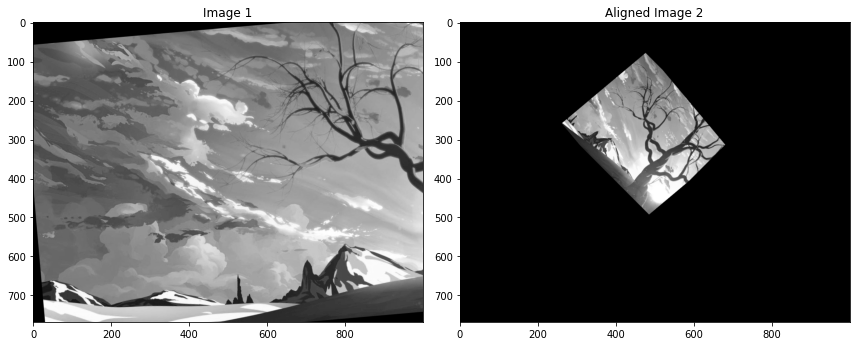

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


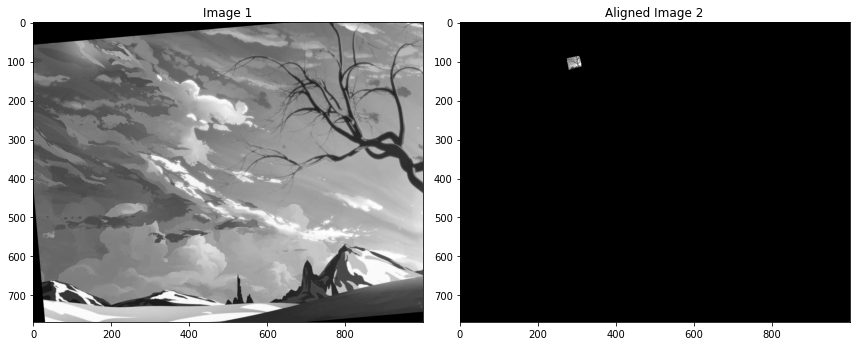

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


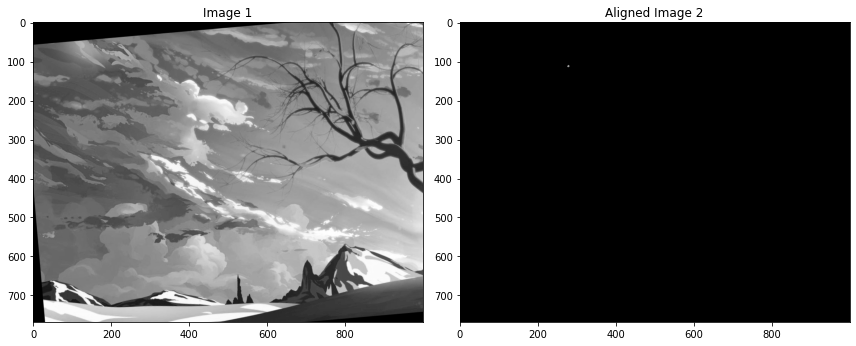

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


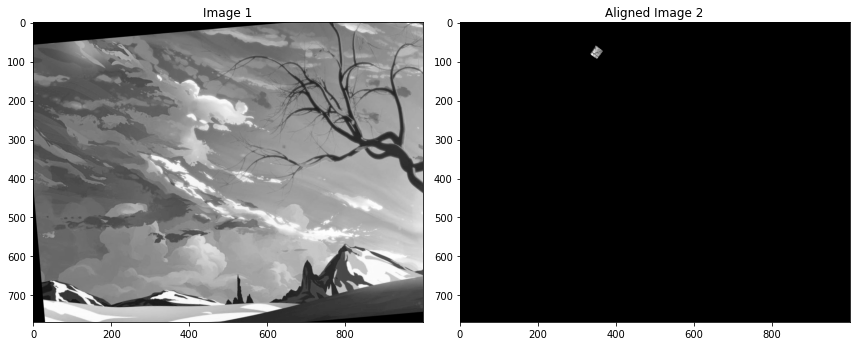

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


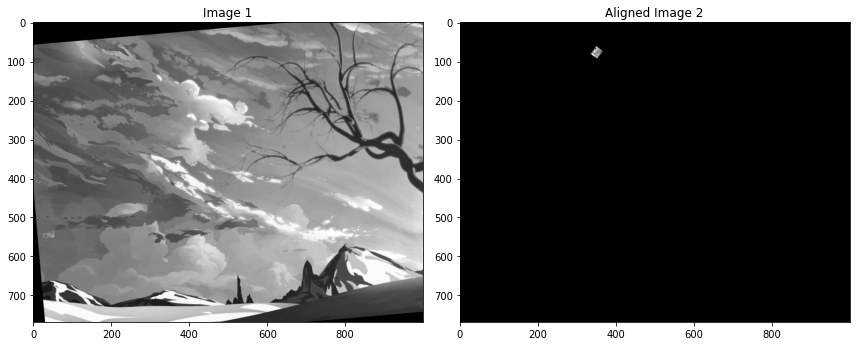

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


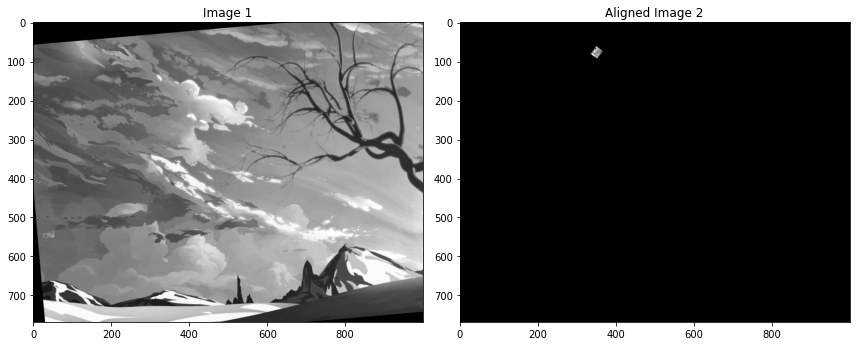

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


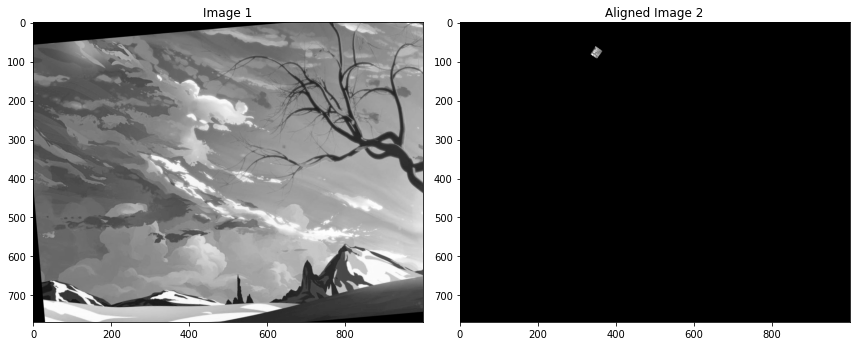

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


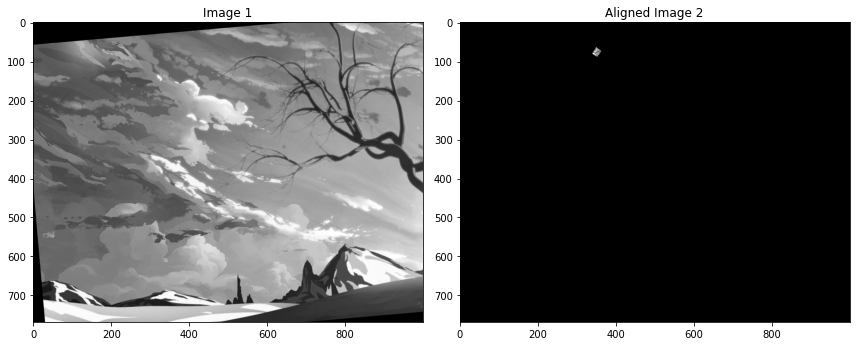

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


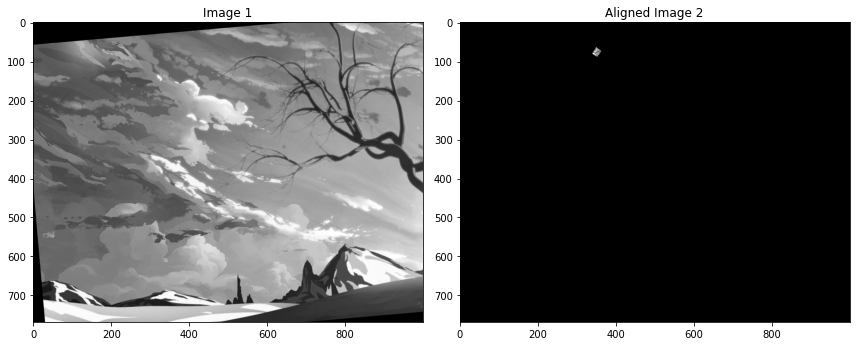

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


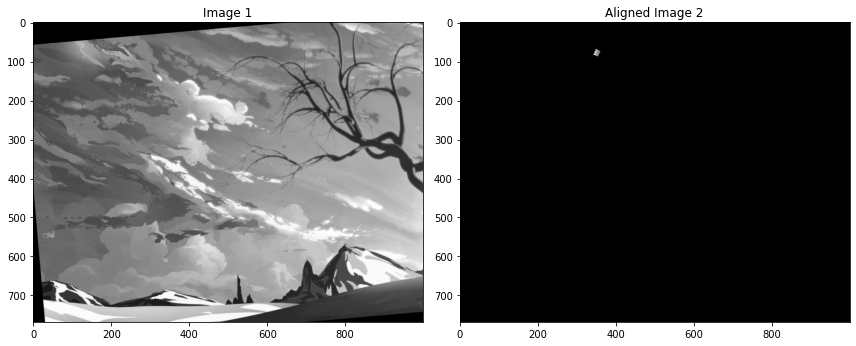

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


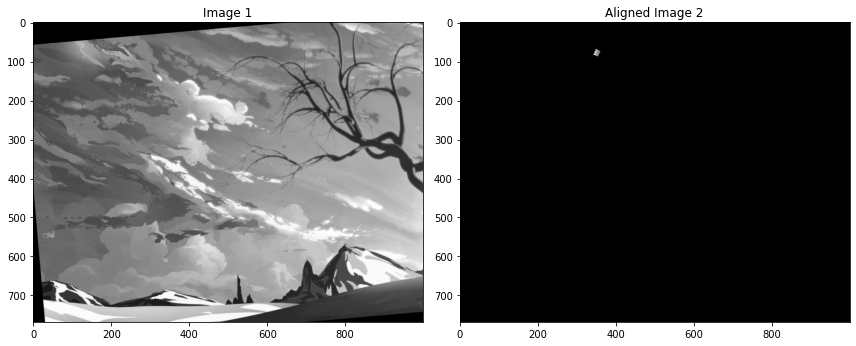

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


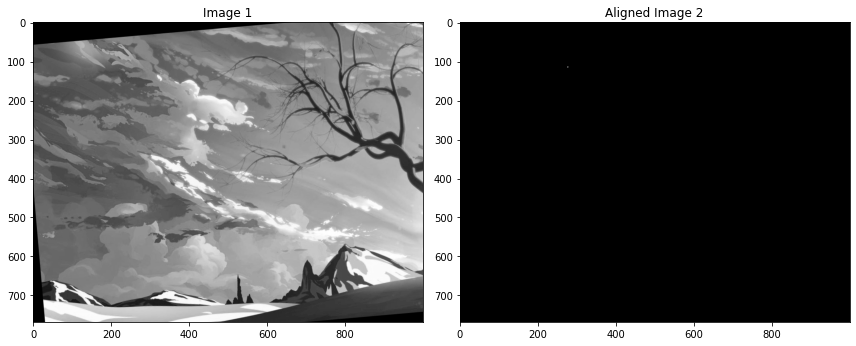

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


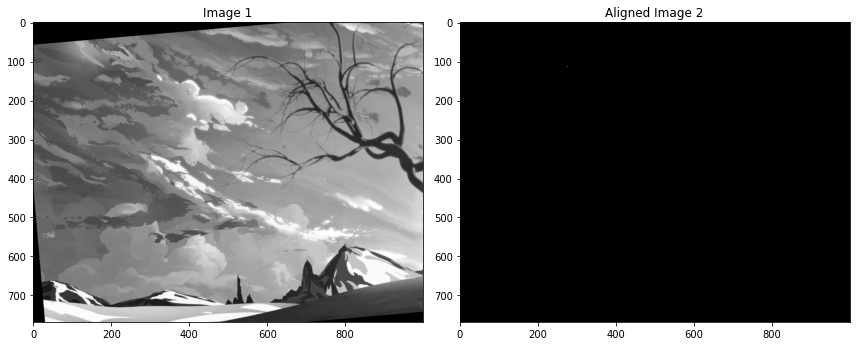

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


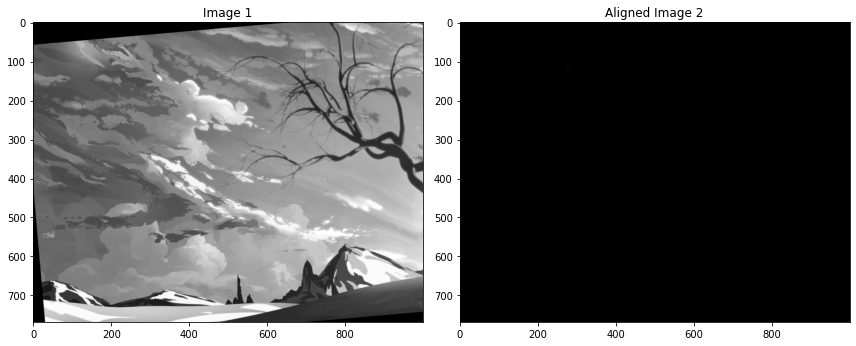

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


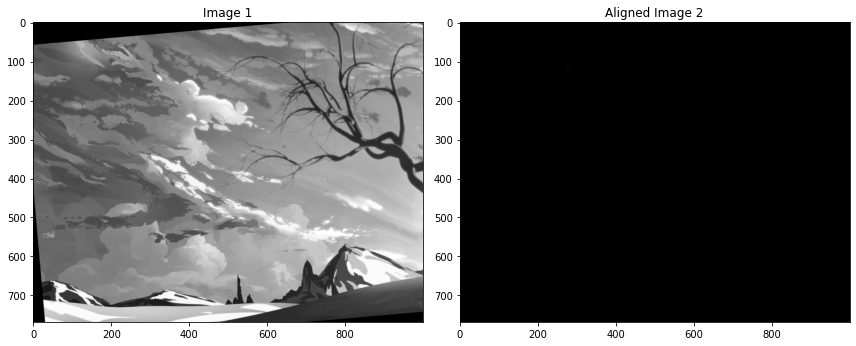

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


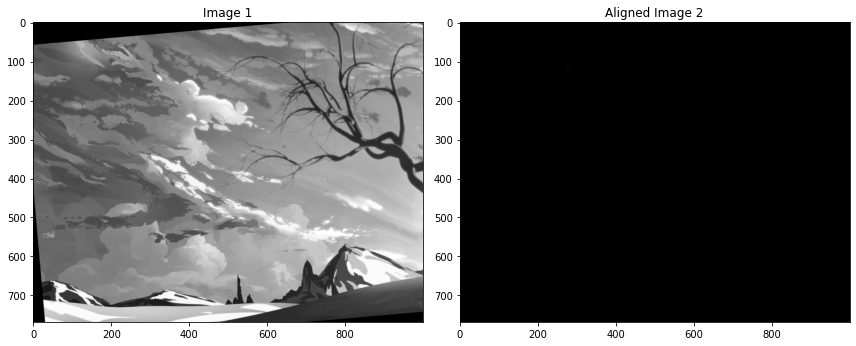

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


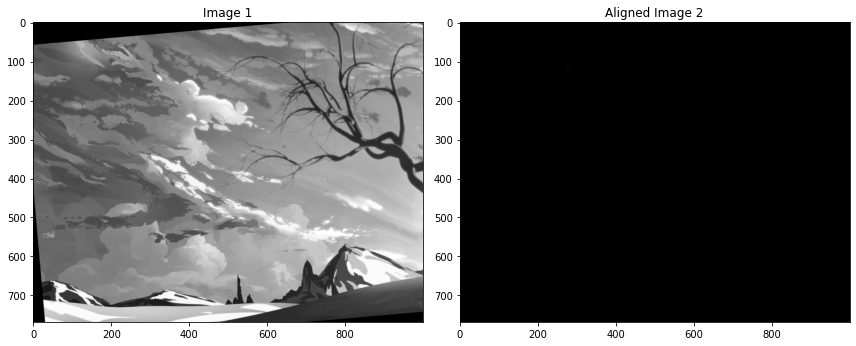

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


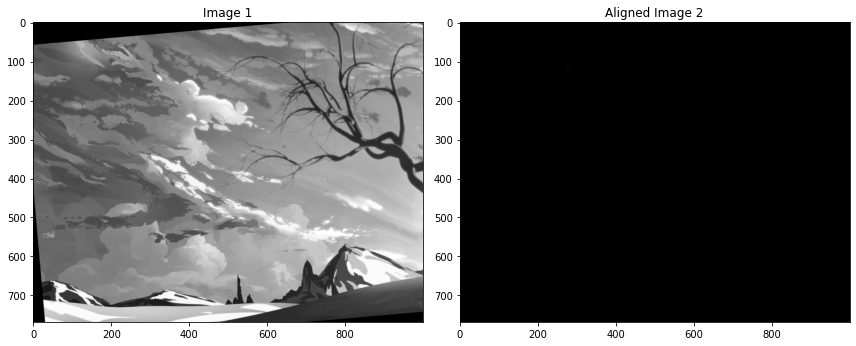

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


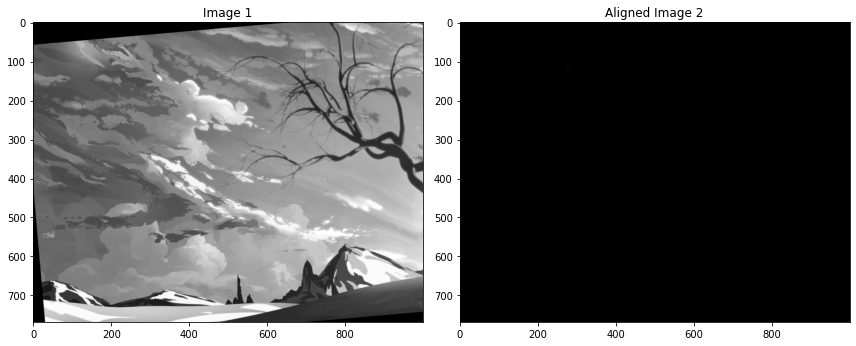

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


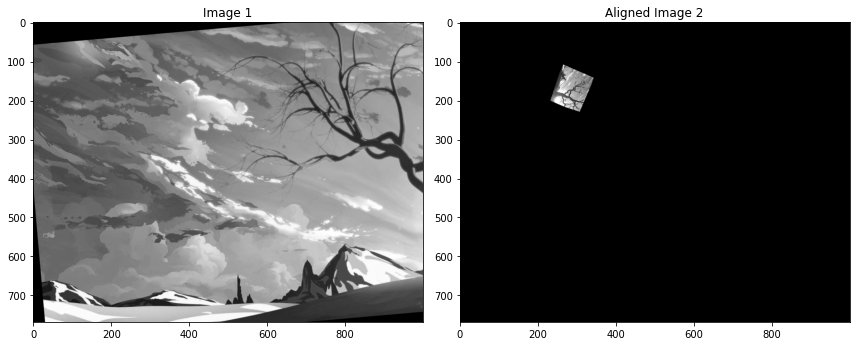

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


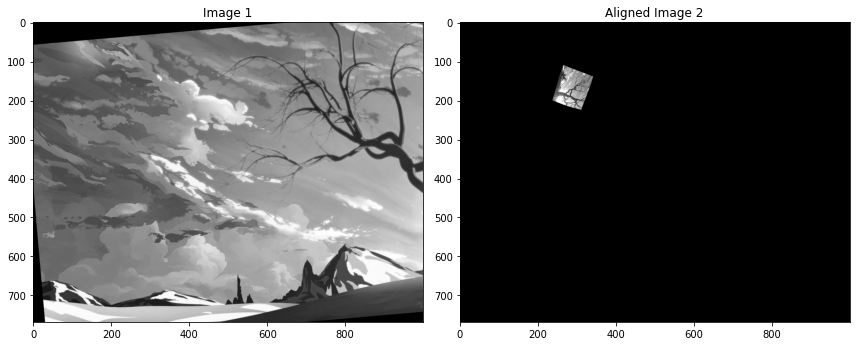

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


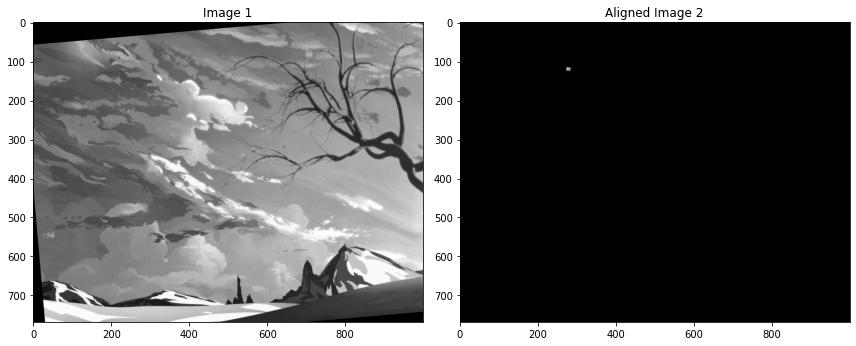

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


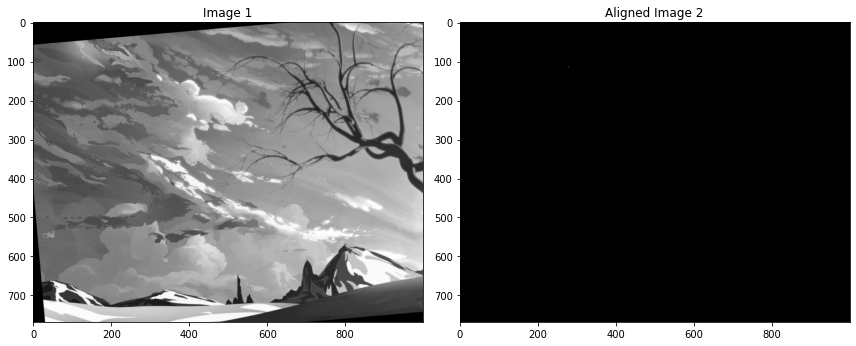

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


KeyboardInterrupt: 

In [133]:
# Convert images to 8-bit format
image1_8bit = np.uint8(img1 * 255)
image2_8bit = np.uint8(img2 * 255)

for i in range(50):
    a_m = get_affine_matrix(SIFT_summary1, SIFT_summary2, nn_model, i)
    # Apply the perspective transformation to the image
    a_m = np.vstack([a_m, np.array([0, 0 ,1])])
    result = cv2.warpPerspective(img2, a_m, (img1.shape[1], img1.shape[0]))

    # Visualize the resulta_m = get_affine_matrix(SIFT_summary1, SIFT_summary2, nn_model)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title('Image 1')

    plt.subplot(1, 2, 2)
    plt.imshow(result, cmap='gray')
    plt.title('Aligned Image 2')

    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.neighbors import NearestNeighbors
best_matrix_error = 1e8

# Get descriptors for both images
SIFT_summary1 = get_SIFT_data(img1, sigmas, downsampling_lvls)
SIFT_summary2 = get_SIFT_data(img2, sigmas, downsampling_lvls)

descriptor1 = SIFT_summary1["Descriptor"].to_list()
descriptor2 = SIFT_summary2["Descriptor"].to_list()

# Initialize NearestNeighbors
k_neighbors = 1  # Number of neighbors to find (in this case, the nearest neighbor)
nn_model = NearestNeighbors(n_neighbors=k_neighbors, algorithm='kd_tree')

# Fit the model on data2 (feature points from image 2)
nn_model.fit(descriptor1)


# affine_matrix = get_affine_matrix(SIFT_summary1, SIFT_summary2, nn_model)

# transform the image by the matrix
# Get the height and width of the image
height, width = img2.shape[:2]

# Apply the affine transformation using warpAffine function from OpenCV
# transformed_image = cv2.warpAffine(img2, affine_matrix[:2, :], (width, height))


for i in range(50):
    affine_matrix = get_affine_matrix(SIFT_summary1, SIFT_summary2, nn_model)
    transformed_image = cv2.warpAffine(img2, affine_matrix[:2, :], (width, height))
    
    SIFT_summary_transformed = get_SIFT_data(transformed_image, sigmas)
    descriptor_transformed_img = SIFT_summary_transformed["Descriptor"].to_list()

    if(len(descriptor_transformed_img)):
        # Query the nearest neighbors for each point in data1
        distances, indices = nn_model.kneighbors(descriptor_transformed_img)

        error = np.sum(distances)
        # Get the height and width of the image
        height, width = img2.shape[:2]

        # Apply the affine transformation using warpPerspective function from OpenCV
        transformed_image = cv2.warpPerspective(img2, affine_matrix, (width, height))

        # Display the image inline using Matplotlib
        plt.imshow(transformed_image, cmap='gray')
        plt.title(f"Error: {error}")
        plt.axis('off')  # Optional: turn off axis labels
        plt.show()
        if error < best_matrix_error:
            best_matrix_error = error
            best_matrix = affine_matrix





In [ ]:
import cv2
import numpy as np

# Define source and destination points
src_pts = np.array([[561, 223], [99, 539], [529, 60]])
dst_pts = np.array([[822, 337], [823, 148], [303, 404]])

# Estimate affine matrix using RANSAC
affine_matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, 
                                                     method=cv2.RANSAC, 
                                                     ransacReprojThreshold=3.0)

if affine_matrix is not None:
    print("Estimated Affine Matrix:")
    print(affine_matrix)
else:
    print("Affine matrix estimation failed.")

# Use affine_matrix for your transformations if it was successfully estimated


Estimated Affine Matrix:
[[-1.92103415e-01 -2.77695500e-01  9.91696112e+02]
 [ 2.77695500e-01 -1.92103415e-01  2.24051886e+02]]


In [ ]:
src_pts.shape

(3, 2)

In [ ]:
# RANSAC parameters
ransac_iterations = 1000  # Number of RANSAC iterations
ransac_threshold = 3.0    # Threshold to determine inliers

# Estimate affine matrix using RANSAC
affine_matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, 
                                                     method=cv2.RANSAC, 
                                                     ransacReprojThreshold=ransac_threshold,
                                                     maxIters=5000)


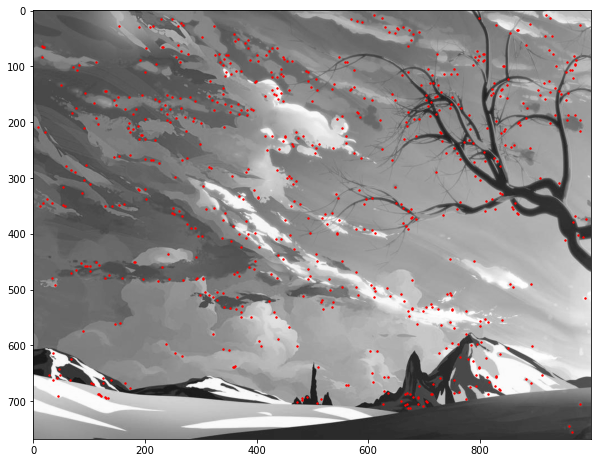

In [ ]:
x1, y1, c = zip(*SIFT_summary1['Position'].to_list())
fig = plt.figure(figsize=(10, 8))
plt.imshow(img1, cmap='gray')  # Display the image
plt.scatter(list(x1), list(y1), color='red', s=2)  # Scatter plot the point (x, y) in red color
plt.show()

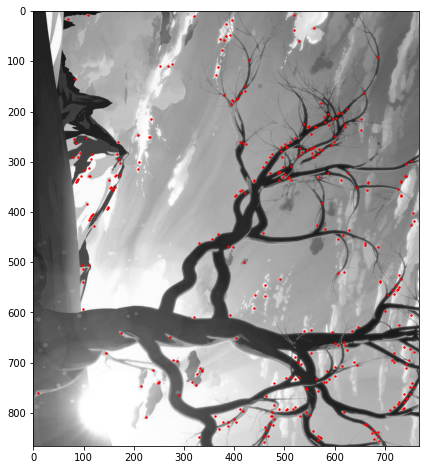

In [ ]:
x2, y2, c = zip(*SIFT_summary2['Position'].to_list())
fig = plt.figure(figsize=(10, 8))
plt.imshow(img2, cmap='gray')  # Display the image
plt.scatter(list(x2), list(y2), color='red', s=2)  # Scatter plot the point (x, y) in red color
plt.show()

In [ ]:
distances, indices = nn_model.kneighbors(descriptor2)


In [ ]:
len(keypoints2)

1902

In [ ]:
affine_matrix = get_affine_matrix(SIFT_summary1, SIFT_summary2, nn_model)

# transform the image by the matrix
# Get the height and width of the image
height, width = img2.shape[:2]

# Apply the affine transformation using warpAffine function from OpenCV
transformed_image = cv2.warpAffine(img2, affine_matrix[:2, :], (width, height))

NameError: name 'get_affine_matrix' is not defined

In [ ]:
affine_matrix.astype(int)

array([[   0,    0, 1404],
       [   0,    0,  213],
       [   0,    0,    1]])

In [ ]:
cv2.imshow('Transformed Image', transformed_image)
cv2.waitKey(0)  # Wait until a key is pressed
cv2.destroyAllWindows()  # Close the window


In [ ]:
np.vstack([matrix2_H, np.ones(3)])

array([[731., 882., 507.],
       [146., 192., 246.],
       [  1.,   1.,   1.]])

In [ ]:
# get nearest neighbors
# Initialize NearestNeighbors
k_neighbors = 1  # Number of neighbors to find (in this case, the nearest neighbor)
nn_model = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto')

# Fit the model on data2 (feature points from image 2)
nn_model.fit(data2)

# Query the nearest neighbors for each point in data1
distances, indices = nn_model.kneighbors(data1)


## Nearest Neighbor search between two images to find similar keypoints

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
# test on a new rotated image
img2 = transform.rotate(img, 16, resize=False)

# fit the nn model on the original image
nn = NearestNeighbors(n_neighbors=1, algorithm="kd_tree").fit(np.array(
    SIFT_summary["Descriptor"].tolist()))

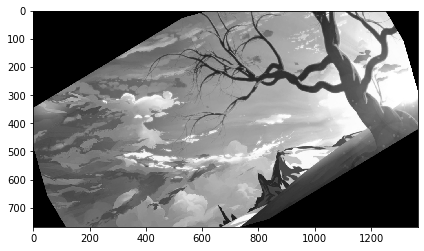

In [ ]:
io.imshow(img2)

In [ ]:
# get descriptors of the new image
sigma = 1.6
k = np.sqrt(2)
downsampling_lvls = [1, 2, 3, 6]
sigmas = [sigma, k * sigma, k**2 * sigma, k**3 * sigma, k**4 * sigma]
%time SIFT_summary1 = get_SIFT_data(img2, sigmas)

Time: 2.520292043685913
Wall time: 3.12 s


In [ ]:
# choose a random feature point from the second image
test_point = SIFT_summary1.sample(1)

# find the nearest neighbor
distances, indices = nn.kneighbors(np.array(test_point["Descriptor"].to_list()), n_neighbors=8)

In [ ]:
test_point

Position  Scale  Orientation  \
46  (1295, 164, 1)    1.6           16   

                                           Descriptor  
46  [0.0, 0.17327229552208492, 0.25661406718491264...

In [ ]:
SIFT_summary.loc[indices[0]]

Position     Scale  Orientation  \
70   (1315, 230, 1)  1.600000           30   
321    (323, 72, 1)  2.262742           29   
63    (686, 213, 1)  1.600000           16   
376   (669, 298, 1)  2.262742           26   
522   (285, 202, 1)  3.200000           29   
333   (339, 105, 1)  2.262742           16   
74   (1304, 233, 1)  1.600000           16   
209   (684, 212, 2)  1.600000           16   
586     (69, 62, 2)  4.525483           15   
19     (770, 86, 1)  1.600000           25   
307    (578, 31, 1)  2.262742           16   
216  (1302, 233, 2)  1.600000           16   
499    (259, 83, 1)  3.200000           14   
154   (1096, 24, 2)  1.600000           25   
40    (662, 152, 1)  1.600000           17   
343   (259, 123, 1)  2.262742           27   
379   (477, 308, 1)  2.262742           16   
498    (431, 78, 1)  3.200000           28   
83    (739, 255, 1)  1.600000           15   
446   (627, 193, 2)  2.262742           16   
287   (351, 597, 2)  1.600000           16   
293   (897, 625, 2)  1.600000           28   
515   (135, 149, 1)  3.200000           16   
117   (450, 474, 1)  1.600000           14   
1     (1045, 15, 1)  1.600000           29   
512   (354, 134, 1)  3.200000           14   
246   (731, 327, 2)  1.600000           20   
493    (238, 69, 1)  3.200000           31   
367   (618, 245, 1)  2.262742           21   
39    (183, 149, 1)  1.600000           16   
312    (327, 42, 1)  2.262742           18   
506    (333, 94, 1)  3.200000           19   
61    (737, 212, 1)  1.600000           16   
68    (805, 227, 1)  1.600000           30   
62   (1302, 212, 1)  1.600000           16   
3     (1129, 24, 1)  1.600000           13   
81    (732, 249, 1)  1.600000           16   
342   (439, 121, 1)  2.262742           21   
290   (879, 613, 2)  1.600000           17   
35    (668, 141, 1)  1.600000           15   
88   (1206, 298, 1)  1.600000           15   
348   (485, 152, 1)  2.262742           17   
152    (881, 17, 2)  1.600000           20   
505    (312, 91, 1)  3.200000           25   
75    (796, 235, 1)  1.600000           27   
588     (88, 84, 2)  4.525483           17   
323    (453, 76, 1)  2.262742           28   
466   (475, 308, 2)  2.262742           19   
524   (280, 220, 1)  3.200000           27   
150   (360, 758, 1)  1.600000           22   

                                            Descriptor  
70   [0.0, 0.32305592820827017, 0.02880471714830384...  
321  [0.0, 0.057885427798925186, 0.084438428408698,...  
63   [0.0, 0.016981582925963946, 0.2898888124599836...  
376  [0.0, 0.18151392986832302, 0.09154139880340222...  
522  [0.12750765350834325, 0.301132713178751, 0.0, ...  
333  [0.0, 0.01972466867170946, 0.2821055113514398,...  
74   [0.0, 0.12182274431114931, 0.2180930429344094,...  
209  [0.0, 0.020645906431204307, 0.2819758134561442...  
586  [0.009525789548127573, 0.12127880996166232, 0....  
19   [0.05471161347734664, 0.15715476926020192, 0.0...  
307  [0.0, 0.0, 0.17565347979615573, 0.049725309775...  
216  [0.001661720747617629, 0.19058499792380856, 0....  
499  [0.0, 0.0, 0.013526510751391047, 0.09304619601...  
154  [0.012013646195392452, 0.5297751319570466, 0.0...  
40   [0.0, 0.0, 0.0492917911998142, 0.2024004648846...  
343  [0.0015793585614181879, 0.016581550189745258, ...  
379  [0.0, 0.0, 0.1056162701565373, 0.0483651848366...  
498  [0.0, 0.05776282059852885, 0.28523299173412076...  
83   [0.0, 0.0, 0.37151407326492075, 0.071080673658...  
446  [0.0, 0.2640343794843814, 0.36767549202497474,...  
287  [0.09860974418901367, 0.286668656189648, 0.0, ...  
293  [0.0, 0.5152493157603231, 0.004033788988218451...  
515  [0.0, 0.0, 0.2680355712368385, 0.0308829344589...  
117  [0.0, 0.2033300557290853, 0.0, 0.0, 0.0, 0.0, ...  
1    [0.0, 0.19972810255864698, 0.1849999099905914,...  
512  [0.0, 0.0, 0.4119321177130367, 0.1192735852771...  
246  [0.006018550608698704, 0.08653924480823057, 0....  
493  [0.0, 0.08773261774968191, 0.08584127053095895...  
367  [0.0, 

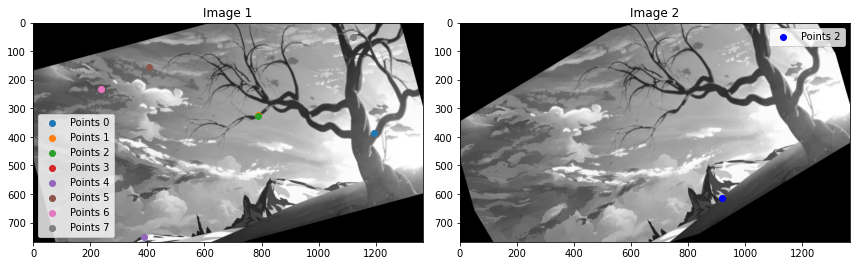

In [ ]:
# plot the two points
x2, y2, _ = test_point["Position"].to_list()[0]


# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display img in the first subplot
ax1.imshow(img, cmap='gray')
ax1.set_title('Image 1')

# Add scatter plot of x1, y1 on img
for i in range(8):
    x1, y1 = SIFT_summary.loc[indices[0]]["Position"].to_list()[i][:2]
    ax1.scatter(x1, y1, marker='o', label=f'Points {i}')
    ax1.legend()

# Display img2 in the second subplot
ax2.imshow(img2, cmap='gray')
ax2.set_title('Image 2')

# Add scatter plot of x2, y2 on img2
ax2.scatter(x2, y2, c='blue', marker='o', label='Points 2')
ax2.legend()

plt.tight_layout()
plt.show()


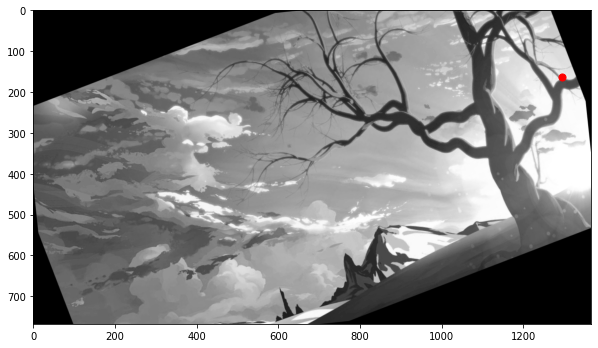

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(img2, cmap='gray')  # Display the image
plt.scatter(x, y, color='red', s=50)  # Scatter plot the point (x, y) in red color
plt.show()

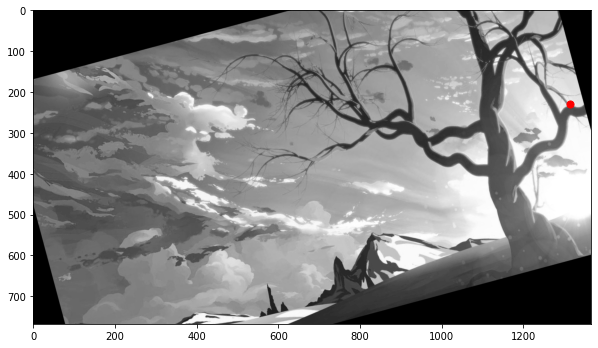

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')  # Display the image
for i in range(1):
    x, y = SIFT_summary.loc[indices[0]]["Position"].to_list()[i][:2]
    plt.scatter(x, y, color='red', s=50)  # Scatter plot the point (x, y) in red color
plt.show()

In [ ]:
test_point["Descriptor"]

10808    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010...
Name: Descriptor, dtype: object

In [ ]:
SIFT_summary.loc[indices[0]]["Descriptor"]

3636     [0.0, 0.0, 0.0, 0.008713706298182623, 0.0, 0.0...
3633     [0.0, 0.0, 0.0, 0.011546661183370116, 0.0, 0.0...
3635     [0.0, 0.0, 0.0, 0.009636456161153287, 0.0, 0.0...
3634     [0.0, 0.0, 0.0, 0.01066978708340055, 0.0, 0.0,...
15148    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.042...
15150    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.042...
3637     [0.0, 0.0, 0.0, 0.008183506395345149, 0.0, 0.0...
3632     [0.0, 0.0, 0.0, 0.05611913901331921, 0.0, 0.0,...
15149    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.049...
746      [0.0, 0.0, 0.003761142592971592, 0.0, 0.0, 0.0...
Name: Descriptor, dtype: object

1. Get nearest neighbors
2. Get affine matrix using ransac
3. optimize using LM